# Imports

In [1]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [2]:
def groupby_min(df, dur):
    temp = df.copy()
    temp.index = map(lambda x: pd.datetime.combine(datetime.datetime.today()
                                                   , x), temp.index.time)
    return temp.resample(dur).mean()

def plot_camera_avg(df, cam=None, dur="1Min"):
    if cam == None:
        weekday = groupby_min(df[(df.index.weekday < 5)], dur)
        weekend = groupby_min(df[(df.index.weekday >= 5)], dur)

    else:
        weekday = groupby_min(df[(df.index.weekday < 5) & 
                                 (df.cam_id == cam)], dur)
        weekend = groupby_min(df[(df.index.weekday >= 5) & 
                                 (df.cam_id == cam)], dur)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    
    weekday["count"].plot(ax=ax1, c="k", alpha=0.5, label="Weekday")
    weekend["count"].plot(ax=ax1, c="b", alpha=0.5, label="Weekend")

    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.grid(True, which="both")
    ax1.tick_params(axis="both", which="both", labelsize=12)
    ax1.legend(ncol=3, fontsize=12)
    
    return fig, ax1

# Load Data

In [3]:
counts = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str,
                        "count": int, "imtime": str}, parse_dates=["date"],
                 infer_datetime_format=True, index_col="date")
counts.head(2)

,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [4]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


In [5]:
df = counts[["cam_id", "count"]].reset_index() \
        .merge(cams[cams["people"] == 1.][["cam_id", "boro", "description"]]) \
        .set_index("date")
df.head(2)

,cam_id,count,boro,description
date,,,,
2017-06-27 20:09:22,368,1,Manhattan,1 Ave @ 110 St
2017-06-27 20:10:39,368,1,Manhattan,1 Ave @ 110 St


In [6]:
mta = pd.read_csv("../data/external/turnstile_170729.txt", parse_dates=["DATE"]) \
        .rename(columns=lambda x: x.strip())
mta.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-07-22,00:00:00,REGULAR,6262933,2121633
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-07-22,04:00:00,REGULAR,6262960,2121637


# Turstile Analysis

In [80]:
cams[cams["description"] == "1 Ave @ E 14 St"]

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
106,789,696,1 Ave @ E 14 St,40.731331,-73.982561,1.0,1.0,Manhattan,10009


In [81]:
mta[(mta["STATION"] == '1 AV') & (mta["LINENAME"] == 'L') & (mta["DATE"].dt.weekday < 5)]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
29335,H007,R248,00-00-00,1 AV,L,BMT,2017-07-24,00:00:00,REGULAR,12548571,13880879
29336,H007,R248,00-00-00,1 AV,L,BMT,2017-07-24,04:00:00,REGULAR,12548598,13880961
29337,H007,R248,00-00-00,1 AV,L,BMT,2017-07-24,08:00:00,REGULAR,12548919,13881715
29338,H007,R248,00-00-00,1 AV,L,BMT,2017-07-24,12:00:00,REGULAR,12550088,13882791
29339,H007,R248,00-00-00,1 AV,L,BMT,2017-07-24,16:00:00,REGULAR,12550750,13883554
29340,H007,R248,00-00-00,1 AV,L,BMT,2017-07-24,20:00:00,REGULAR,12551664,13884481
29341,H007,R248,00-00-00,1 AV,L,BMT,2017-07-25,00:00:00,REGULAR,12552041,13884998
29342,H007,R248,00-00-00,1 AV,L,BMT,2017-07-25,04:00:00,REGULAR,12552070,13885077
29343,H007,R248,00-00-00,1 AV,L,BMT,2017-07-25,08:00:00,REGULAR,12552419,13885912
29344,H007,R248,00-00-00,1 AV,L,BMT,2017-07-25,12:00:00,REGULAR,12553772,13887041


In [82]:
turnstiles = mta[(mta["STATION"] == '1 AV') & (mta["LINENAME"] == 'L') & (mta["DATE"].dt.weekday < 5)].groupby(["SCP", "DATE", "TIME"]).sum()

for idx, row in turnstiles.iterrows():
    scp = 0
    row_0 = row.copy()
    if ((idx[0] != scp) & (idx[2] == "01:00:00")):
        entries_0 = row_0.ENTRIES
        exits_0 = row_0.EXITS
        turnstiles.loc[idx]["ENTRIES"] = 0
        turnstiles.loc[idx]["EXITS"] = 0
        scp = idx[0]
    else:
        turnstiles.loc[idx]["ENTRIES"] = row_0.ENTRIES - entries_0
        turnstiles.loc[idx]["EXITS"] = row_0.EXITS - exits_0
    entries_0 = row_0.ENTRIES
    exits_0 = row_0.EXITS
    
    if abs(turnstiles.loc[idx]["ENTRIES"]) > 10000:
        turnstiles.loc[idx]["ENTRIES"] = 0
        turnstiles.loc[idx]["EXITS"] = 0

def avg_exits(row):
    if row.index[0] == "01:00:00":
        return 1. * row.EXITS / 6
    else:
        return 1. * row.EXITS / 7
    
def avg_entries(row):
    if row.index[0] == "01:00:00":
        return 1. * row.ENTRIES / 6
    else:
        return 1. * row.ENTRIES / 7
        
data = turnstiles.reset_index().drop(["DATE"], axis=1).groupby(["SCP", "TIME"]).sum().reset_index().groupby(["TIME"]).sum()
data["AVG_EXITS"] = data.apply(avg_exits, axis=1)
data["AVG_ENTRIES"] = data.apply(avg_entries, axis=1)
data["DIFF"] = data.AVG_EXITS - data.AVG_ENTRIES
data["SUM"] = data.AVG_ENTRIES + data.AVG_EXITS
data[data.AVG_EXITS > 300]

,ENTRIES,EXITS,AVG_EXITS,AVG_ENTRIES,DIFF,SUM
TIME,,,,,,
00:00:00,14590,12553,1793.285714,2084.285714,-291.000000,3877.571429
04:00:00,3282,2203,314.714286,468.857143,-154.142857,783.571429
08:00:00,6814,13570,1938.571429,973.428571,965.142857,2912.000000
12:00:00,23792,20503,2929.000000,3398.857143,-469.857143,6327.857143
16:00:00,19272,18937,2705.285714,2753.142857,-47.857143,5458.428571
20:00:00,32177,31830,4547.142857,4596.714286,-49.571429,9143.857143


In [83]:
tmp_  = data[data.AVG_EXITS > 300][["DIFF"]]
tmp_ = (tmp_ - tmp_.min()) / (tmp_.max() - tmp_.min())
tmp_.index = [pd.to_datetime(pd.datetime.today().strftime("%Y-%m-%d ") + i) for i in tmp_.index]

/Users/JordanVani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/JordanVani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/JordanVani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



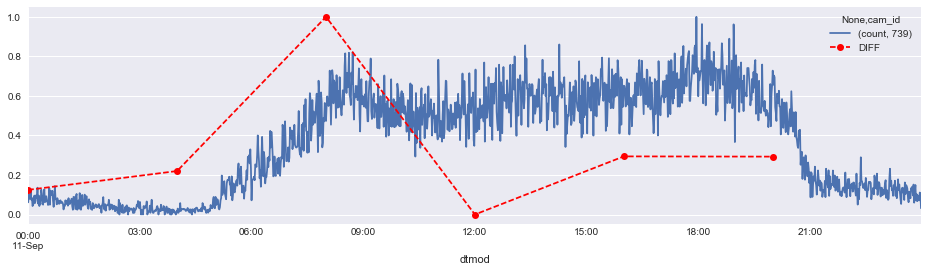

In [84]:
tmp = df[(df.cam_id == 739) & (df.index.weekday < 5)]
tmp["t"] = tmp.index.time
tmp["d"] = pd.datetime.today().date()
tmp["dtmod"] = [pd.datetime.combine(i, j) for i, j in zip(tmp.d, tmp.t)]
tmp.set_index("dtmod", inplace=True)
tmp = tmp.groupby("cam_id").resample("1 Min").mean()[["count"]].unstack(level=0)
tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
tmp.plot(ax=ax1)
tmp_.plot(c='r', ax=ax1, marker="o", ls="dashed")